In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The data is given to us in MBO and MBP-1 formats
which are table schema

https://databento.com/docs/schemas-and-data-formats/whats-a-schema?historical=python&live=python&reference=python

## Solution
In section 2.2 we will implement the formula for $I_t$


In [34]:
df = pd.read_csv("merged_data.csv")
# Add a second offset column
df = df.reset_index(names="time")
df.head(5)

,time,ts_event,bid_fill,ask_fill,Signed Volume,price,best_bid,best_ask,mid_price
0,0,2024-10-22 08:00:00,801.0,1999.0,-1198.0,236.14,235.83,236.14,235.985
1,1,2024-10-22 08:00:01,201.0,202.0,-1.0,236.13,235.83,236.13,235.980
2,2,2024-10-22 08:00:02,1600.0,1400.0,200.0,235.83,235.83,236.11,235.970
3,3,2024-10-22 08:00:03,534.0,400.0,134.0,236.10,235.96,236.10,236.030
4,4,2024-10-22 08:00:04,400.0,502.0,-102.0,236.11,235.96,236.11,236.035


## Since we are not working with a smooth strategy (the data incidates that Q(t) is a step function) 
the integral
$J^n_t = \int_0^t K_n(t-s) \, dQ_s$ becomes a finite sum 

$J^n_t = \sum_{s_i < t} K_n(t-s_i)\cdot \Delta Q_{s_i}$

where 
- $t$ fixed in the future
- $s_i$ are the times (`ts_event`) earlier than $t$
- $\Delta Q_{s_i} = Q_{s_i} - Q_{s_{i-1}}$ where we set $Q_{0} = 0$ . Example: $Q_{1} = -1198$ and $Q_{3} = -999$

#### Calculate $J^n_t$

In [35]:
class OWModel:
    def __init__(self):
        pass

    def h_func(self, x : float, lamb : float = 1.0) -> float:
        return lamb * x
    
    def K_func(self, t : float, beta : float = 1.0) -> float:
        return np.exp(-1 * beta * t)
    

class AFSModel:
    def __init__(self):
        pass

    def h_func(self, x : float, lamb : float, p : float) -> float:
        return np.sign(x) * lamb * np.abs(x)**p
    
    def K_func(self, t : float, beta : float = 1.0) -> float:
        return np.exp(-1 * beta * t)

In [76]:
def generate_price_impact_t(current_time : int, df = df, lamb = 1, beta = 1):
    assert current_time in df['time']

    copy_df = df.copy()

    ow= OWModel()

    copy_df['K_vals'] = copy_df[['time']].apply(lambda row: ow.K_func(t = current_time - row[0], beta=beta), axis = 1) 
    copy_df['J_vals'] = copy_df['K_vals'].cumsum()


    subset = copy_df[copy_df['time'] <= current_time]

    subset["h(J)"] = subset[['J_vals']].apply(lambda row: ow.h_func(x = row[0], lamb=lamb), axis = 1)


    # subset['I_t'] = subset['h(J)'].cumsum()


    return subset








In [77]:
test = generate_price_impact_t(50, df = df, lamb=1, beta=0.1)

/var/folders/nh/m91qpv214t9b8xssz75rnw580000gn/T/ipykernel_4414/852906398.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  copy_df['K_vals'] = copy_df[['time']].apply(lambda row: ow.K_func(t = current_time - row[0], beta=beta), axis = 1)
/var/folders/nh/m91qpv214t9b8xssz75rnw580000gn/T/ipykernel_4414/3344596577.py:9: RuntimeWarning: overflow encountered in exp
  return np.exp(-1 * beta * t)
/Users/80095022/Desktop/blockhouse_work_trial/paper/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/var/folders/nh/m91qpv214t9b8xssz75rnw580000gn/T/ipykernel_4414/852906398.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as label

<Axes: xlabel='Time', ylabel='Price impact'>

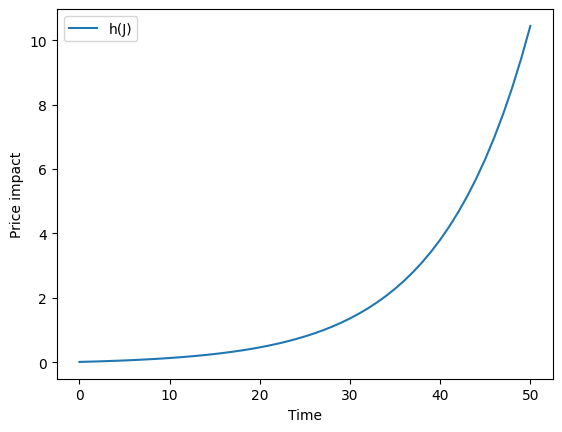

In [78]:
test[['h(J)']].plot(kind = 'line', use_index=True, xlabel="Time", ylabel="Price impact")

In [79]:
def generate_price_impact_t_AFS(current_time : int, df = df, lamb = 1, beta = 1, p = 1):
    assert current_time in df['time']

    copy_df = df.copy()

    ow= AFSModel()

    copy_df['K_vals'] = copy_df[['time']].apply(lambda row: ow.K_func(t = current_time - row[0], beta=beta), axis = 1) 
    copy_df['J_vals'] = copy_df['K_vals'].cumsum()

    subset = copy_df[copy_df['time'] <= current_time]

    subset["h(J)"] = subset[['J_vals']].apply(lambda row: ow.h_func(x = row[0], lamb=lamb, p =p), axis = 1)


    # subset['I_t'] = subset['h(J)'].cumsum()


    return subset








/var/folders/nh/m91qpv214t9b8xssz75rnw580000gn/T/ipykernel_4414/23216938.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  copy_df['K_vals'] = copy_df[['time']].apply(lambda row: ow.K_func(t = current_time - row[0], beta=beta), axis = 1)
/var/folders/nh/m91qpv214t9b8xssz75rnw580000gn/T/ipykernel_4414/3344596577.py:20: RuntimeWarning: overflow encountered in exp
  return np.exp(-1 * beta * t)
/Users/80095022/Desktop/blockhouse_work_trial/paper/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/var/folders/nh/m91qpv214t9b8xssz75rnw580000gn/T/ipykernel_4414/23216938.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels

<Axes: xlabel='Time', ylabel='Price impact'>

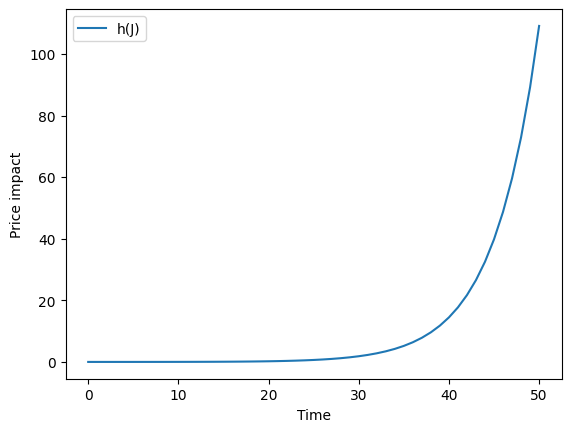

In [82]:
test2 = generate_price_impact_t_AFS(current_time = 50, df = df, lamb = 1, beta = 0.1, p = 2)
test2[['h(J)']].plot(kind = 'line', use_index=True, xlabel="Time", ylabel="Price impact")